In [1]:
%load_ext autoreload
%autoreload 2

# Fundamentals of Social Data Science
# Week 3. Day 3. Distance 

Today we will start off where the last lab ended. In case you did not get through the lab or found it tricky to manage, have a look at this repository now. Today we will not be using the TF-IDF vectors for the words to look at distance or similarity within the different corpora. 

However, in order to do a suitable job at this and have it build on the previous day's code, I would like you to see how I have refactored the methods in the lab into an entire GitHub package. Here are some things to consider about this package: 
- **Settings**: I have placed all my settings in a config.py file
- **Models**: The previous code had a _class_ in it, `Reddit_Scraper`. Classes typically go in a folder called 'models' and are then referenced around the project. 
- **Utilities**: Whenever we want to analyse data we can wrap that in a function. These functions we can place in a utilities folder. 

Each of the folders has an __init__.py file. Those are used in case we want to `import utils`. Then it will include utils. However we can also import these things directly. 

Today we will simply plot these TF-IDF vectors since I think there is much time worth spending simply trying to understand how we got the code from where it was in a Jupyter cell into all these places here and why they make sense as we build out our analysis. 

These different files and locations made it easier for me to organise the different things that I wanted to do with my files including:
- have a cache. 
- have a DataFrame object that I could work with.
- separate out results as objects from results as printed feedback. 

This sort of code organisation is difficult. I am not assuming that you would have known to do this on your own. When I used to anaylse data I might have a very long list of Jupyter cells with some output in between. Things were very linear in terms of steps. I am using this code not as necessarily what I would expect out of you from what we have seen in the class, but more as a model for how you might understand the process of _refactoring_. As our code scales, it is necessary to refactor it so that we can manage different sections of the code. This involves more than just functions. It can involve entire swaths of code. 

Below see how I go through the workflow steps for this project: 
1. Import my config settings (so you would want to set that yourself)
2. Get the reddit posts. These will then be cached. If you use a different limit you will get a different cache. The default is that it refreshes every 24 hours. We would not store the data here permanently, this is just so that we do not hammer the server when working on the code. 
3. Get the TFIDF results. This now comes down as a dictionary with four objects in it: 
    - 'tfidf_matrix': The tfidf matrix as a numpy object 
    - 'feature_names': The names of the words
    - 'freq_df': A DataFrame of words and their frequency in the corpus
    - 'vocab_stats': Some quick stats about the data.
4. Get a DataFrame with the tfidf scores. This we can then sort to only look at the top N words. 
5. Plot the keywords over time using `plot_word_timeseries()`.
6. Interrogate this with the `include_selftext=True` parameter in my analyses.

This gets us from where we were yesterday to where I recommended we could be for today. Now we can explore distance both within and between subreddits as well as visualise these distances. Review the code below and check that you can run this with your subs of interest. 

Then let's have a look at how we can visualise and consider the differences in words between the subreddits using vectors. 

The top terms for unitedkingdom are:
man
budget
year
woman
say


,score
term,
man,0.045
budget,0.041
year,0.039
woman,0.034
say,0.034


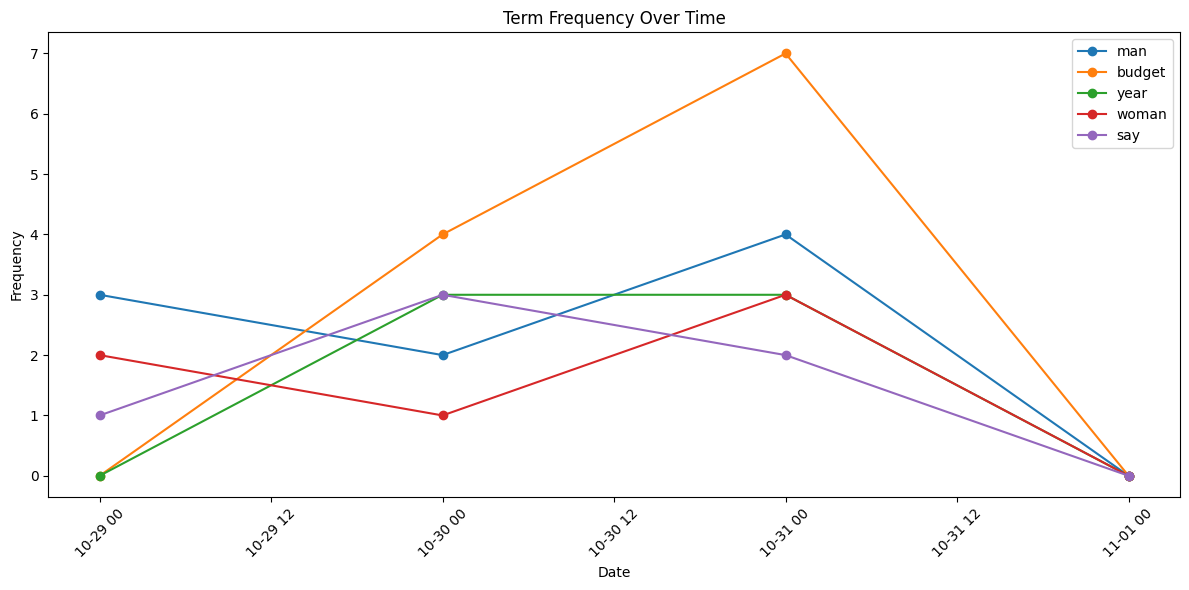

The top terms for ukpolitics are:
budget
labour
tax
reef
say


,score
term,
budget,0.114
labour,0.060
tax,0.045
reef,0.041
say,0.038


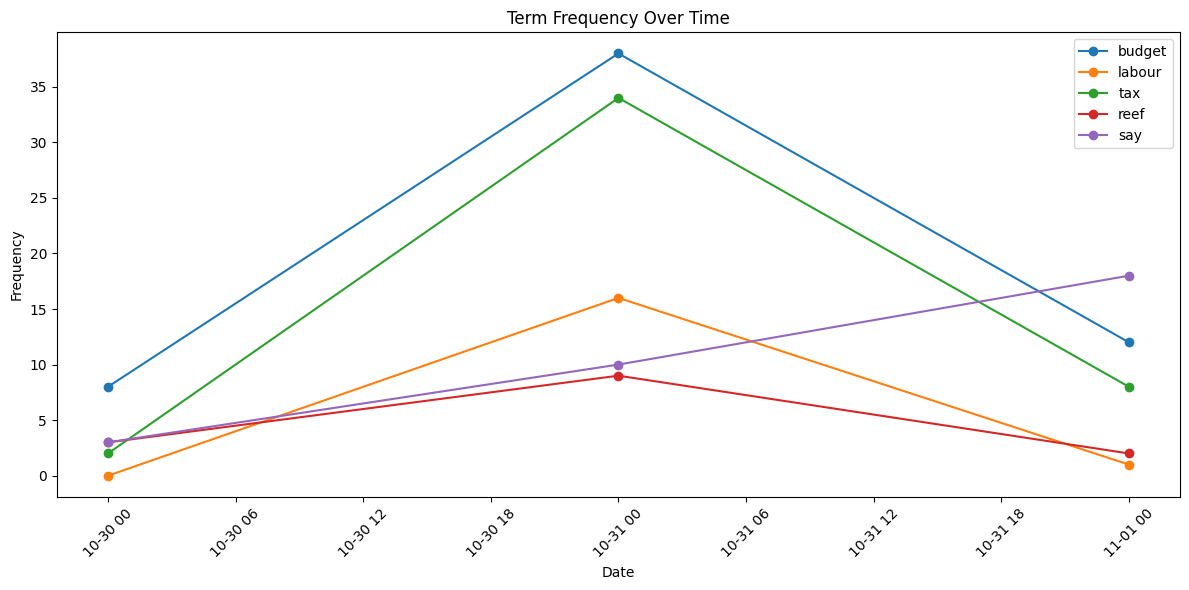

The top terms for uknews are:
budget
news
starmer
tax
labour


,score
term,
budget,0.033
news,0.033
starmer,0.032
tax,0.028
labour,0.027


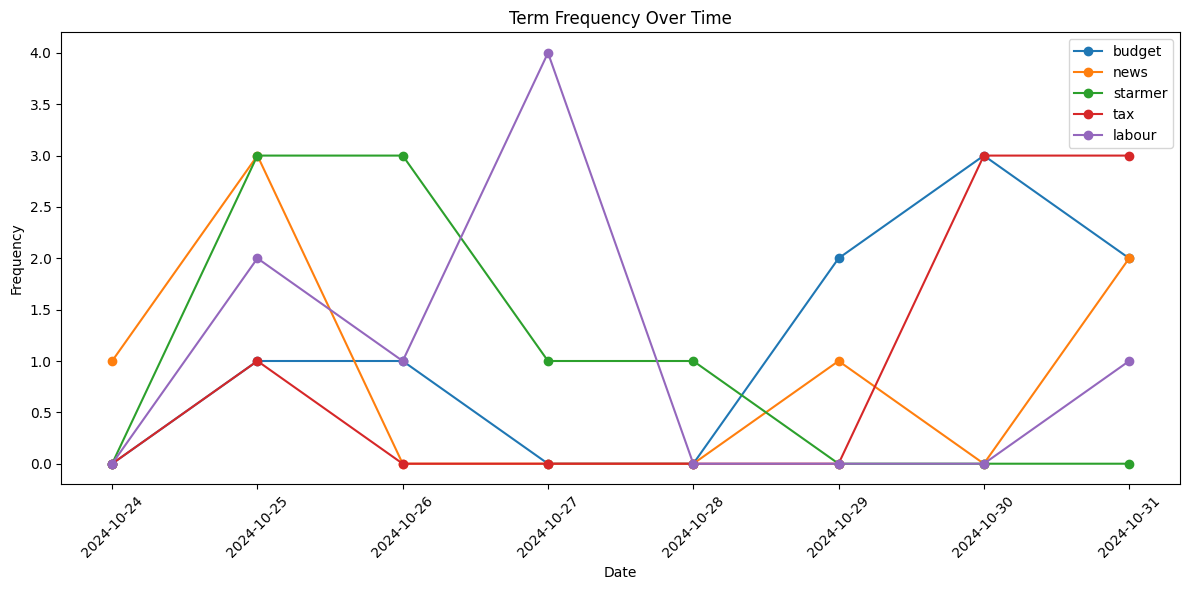

The top terms for london are:
london
tube
best
pub
ticket


,score
term,
london,0.093
tube,0.042
best,0.038
pub,0.026
ticket,0.024


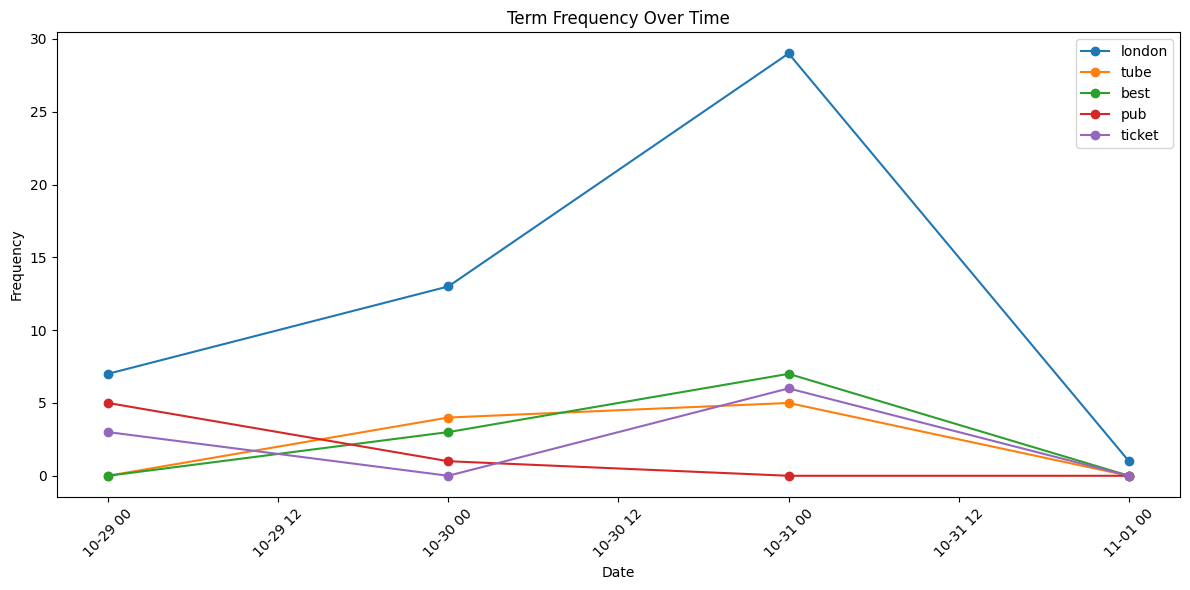

In [ ]:
import os
import pickle
from models.reddit_scraper import RedditScraper
from config.settings import USER_AGENT
from utils.analysis import *


scraper = RedditScraper(USER_AGENT)

subs_of_interest = ['unitedkingdom', 'ukpolitics', 'uknews', 'london']

for sub in subs_of_interest:    
    posts = scraper.get_subreddit_posts(sub, limit=100, cache=True)
    posts_df = create_posts_dataframe(posts)
    
    tfidf_results = tfidf_analyze_subreddit(posts)
    tf_idf_scores = get_mean_tfidf(
        tfidf_matrix=tfidf_results['tfidf_matrix'],
        feature_names=tfidf_results['feature_names'],
        return_df=True
    )
    
    top_terms = get_top_terms(tf_idf_scores, n_terms=5)
    print(f"The top terms for {sub} are:\n", "\n".join(top_terms), sep="")
    display(tf_idf_scores.head().style.format("{:.3f}"))
    
    fig, ax = plot_word_timeseries(posts_df, top_terms)
    plt.show()



# Distance analysis 

First, let's replicate the distance analysis in the walkthrough with real data. Recall that there is no guarantee that the words we thought were going to be in the vocabulary are actually there. So there is no sense necessarily hard coding things like expecting "tax" in the headlines. 

For each of three subreddits we will get a vocabulary. We can then turn these into sets and take the intersection to get the words in common. Even there we already may have some interesting insights about distance.
1. We can report the Jaccard similarity across all of our terms. 
2. We can report the relative rank order of the terms in the intersection. 
3. We can report the terms that are unique to each subreddit within this time window. 

Then considering term vectors: 
- Recalling cosine distance between terms we can create a _cosine matrix_. This we can use to determine the pairwise distances between all the terms. 
- With this cosine matrix we can create a 'projection', meaning we can try to represent this data in a different space. In this case it will be in a two-dimensional space for t-SNE. 
- Finally, we can create different t-SNE maps for each of the subreddits to get a sense of whether the words fall in similar places in the different subreddits. 
- Since we are doing this on a per-subreddit level we can compare the different subs by looking across the pictures. What will we reveal if we include the top 100 terms in our t-SNE or the top terms in the intersection? Which is more illustrative? Just viewing these different diagrams do you think that you could tell based on the words and how they are used which subreddit a post will belong in? 

First I will replicate the analyses above, except this time I will save the results objects in a dictionary with the subreddit name as key. That way I can call upon it again. I will do that to get the vocab and the vocab in common. 

In [ ]:
subs_of_interest = ['unitedkingdom', 'ukpolitics', 'uknews']

results = {} 

for sub in subs_of_interest:    
    posts = scraper.get_subreddit_posts(sub, limit=100, cache=True)
    posts_df = create_posts_dataframe(posts)
    
    tfidf_results = tfidf_analyze_subreddit(posts, include_selftext=True)
    # tfidf_results = tfidf_analyze_subreddit(posts)
    tf_idf_scores = get_mean_tfidf(
        tfidf_matrix=tfidf_results['tfidf_matrix'],
        feature_names=tfidf_results['feature_names'],
        return_df=True
    )
    results[sub] = {"posts_df":posts_df,
                    "tfidf_results":tfidf_results,
                    "tf_idf_scores":tf_idf_scores}


# Ensure the data directory exists
os.makedirs("data", exist_ok=True)

# Just a backup of all the files, not used in the analysis directly
with open("data/results.pkl", "wb") as f:
    pickle.dump(results, f)

# Jaccard similarity analysis

In [60]:
# Extract the vocabulary for each subreddit
vocabularies = {sub: set(results[sub]['tfidf_results']['feature_names']) for sub in subs_of_interest}

# Get the intersection of the vocabularies
common_vocab = set.intersection(*vocabularies.values())

# Report analytics
print(f"Number of common terms across all subreddits: {len(common_vocab)}")
print(f"Common terms: {', '.join(list(common_vocab)[:10])}...")  # Display first 10 common terms

# Calculate Jaccard similarity for each pair of subreddits
for sub1 in subs_of_interest:
    for sub2 in subs_of_interest:
        if sub1 > sub2:
            intersection = vocabularies[sub1].intersection(vocabularies[sub2])
            union = vocabularies[sub1].union(vocabularies[sub2])
            jaccard_similarity = len(intersection) / len(union)
            print(f"Jaccard similarity between {sub1} and {sub2}: {jaccard_similarity:.3f}")

# Report unique terms for each subreddit
for sub in subs_of_interest:
    unique_terms = vocabularies[sub] - common_vocab
    print(f"Number of unique terms in {sub}: {len(unique_terms)}")
    print(f"Unique terms in {sub}: {', '.join(list(unique_terms)[:10])}...")  # Display first 10 unique terms

Number of common terms across all subreddits: 26
Common terms: give, live, new, budget, attack, life, say, first, use, time...
Jaccard similarity between unitedkingdom and ukpolitics: 0.130
Jaccard similarity between unitedkingdom and uknews: 0.172
Jaccard similarity between ukpolitics and uknews: 0.126
Number of unique terms in unitedkingdom: 89
Unique terms in unitedkingdom: ahead, country, govt, force, fail, street, girl, three, trial, officer...
Number of unique terms in ukpolitics: 312
Unique terms in ukpolitics: country, employer, exempt, turn, growth, party, raid, mile, employment, many...
Number of unique terms in uknews: 138
Unique terms in uknews: lay, hotel, sucker, worker, detect, nazi, girl, raid, minimum, tommy...


## Terms in common across all subreddits

In [61]:
import pandas as pd
import numpy as np

# Create a dataframe for the common terms
common_terms_df = pd.DataFrame(index=list(common_vocab))

# Add TF-IDF scores for each subreddit
for sub in subs_of_interest:
    common_terms_df[sub] = results[sub]['tf_idf_scores'].reindex(common_vocab)['score']

# Calculate the average TF-IDF score (mean)
common_terms_df['average'] = common_terms_df.mean(axis=1)

# Sort by the average score
common_terms_df = common_terms_df.sort_values(by='average', ascending=False)

# Report the top 5 words
top_5_words = common_terms_df.head(5)
print(top_5_words)

        unitedkingdom  ukpolitics    uknews   average
budget       0.036617    0.088575  0.033601  0.052931
tax          0.014837    0.043501  0.027735  0.028691
year         0.039337    0.023326  0.019659  0.027440
say          0.033724    0.042380  0.005854  0.027320
news         0.029765    0.014004  0.032904  0.025557


# Plotting word similarities using MDS 

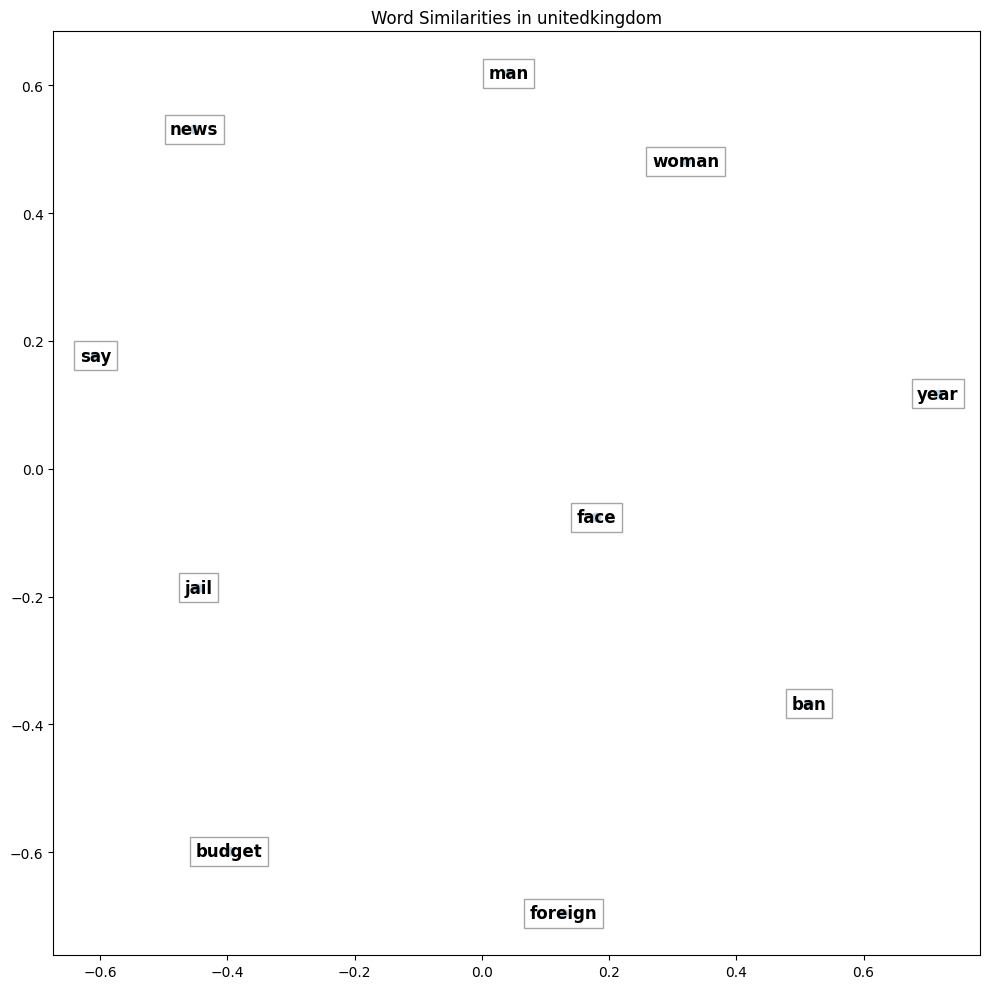

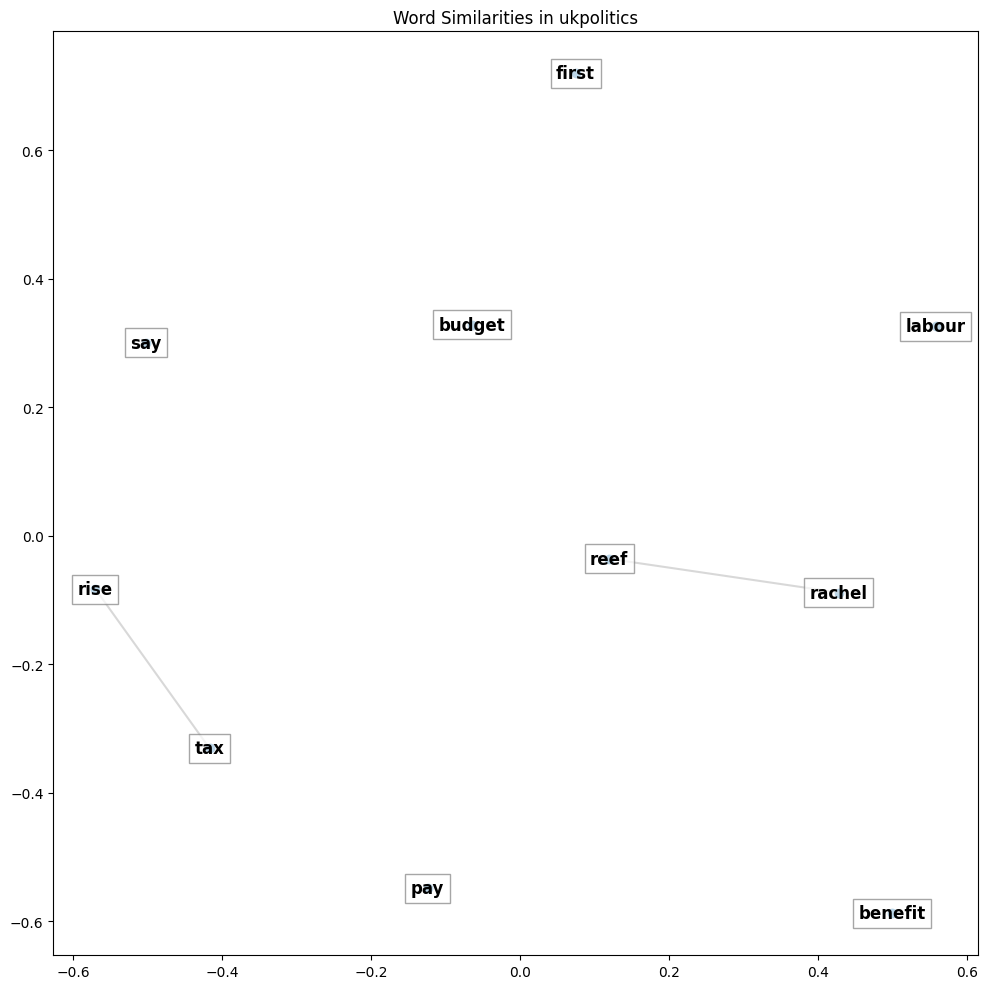

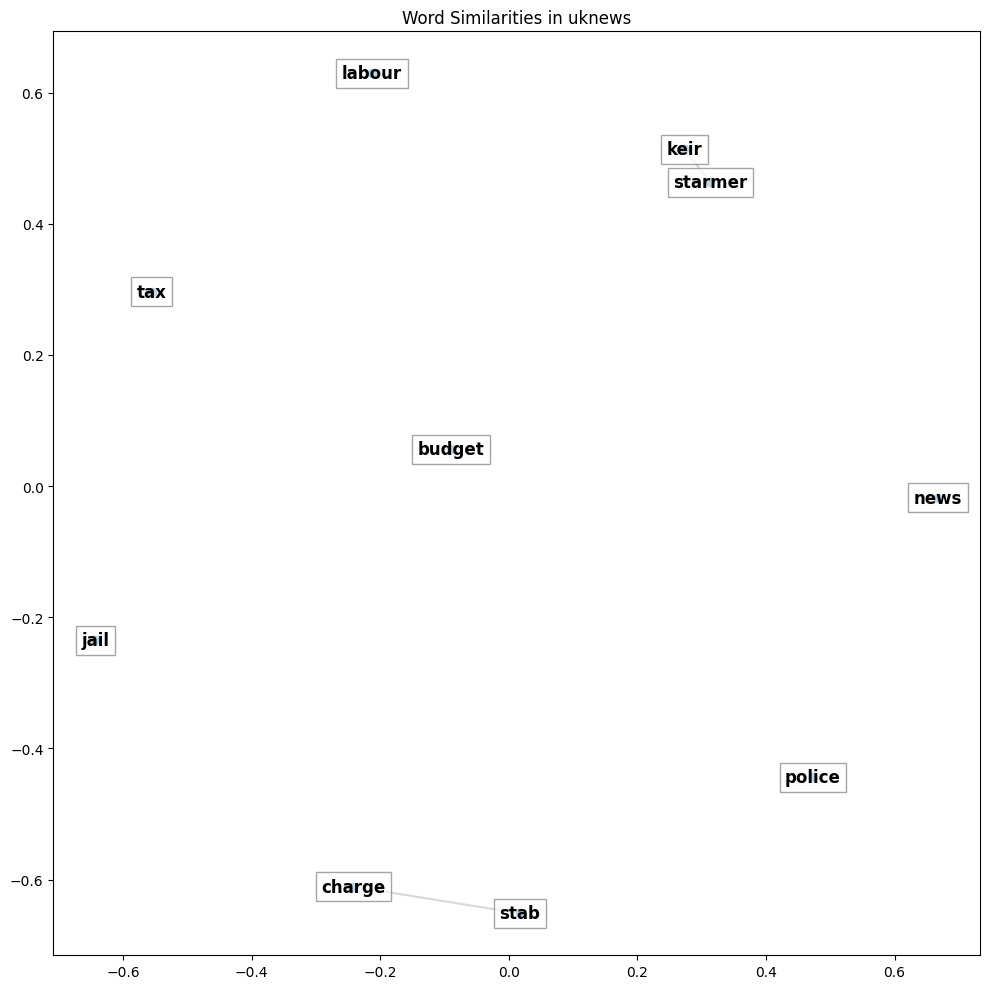

In [ ]:
from utils.analysis import plot_word_similarities

for sub in subs_of_interest:
    fig, ax = plot_word_similarities(results[sub]['tfidf_results']['tfidf_matrix'], 
                                     results[sub]['tfidf_results']['feature_names'],
                                     n_terms=10, # Try changing this value
                                     title=sub)
    plt.show();

# Plot the word similarities using t-SNE

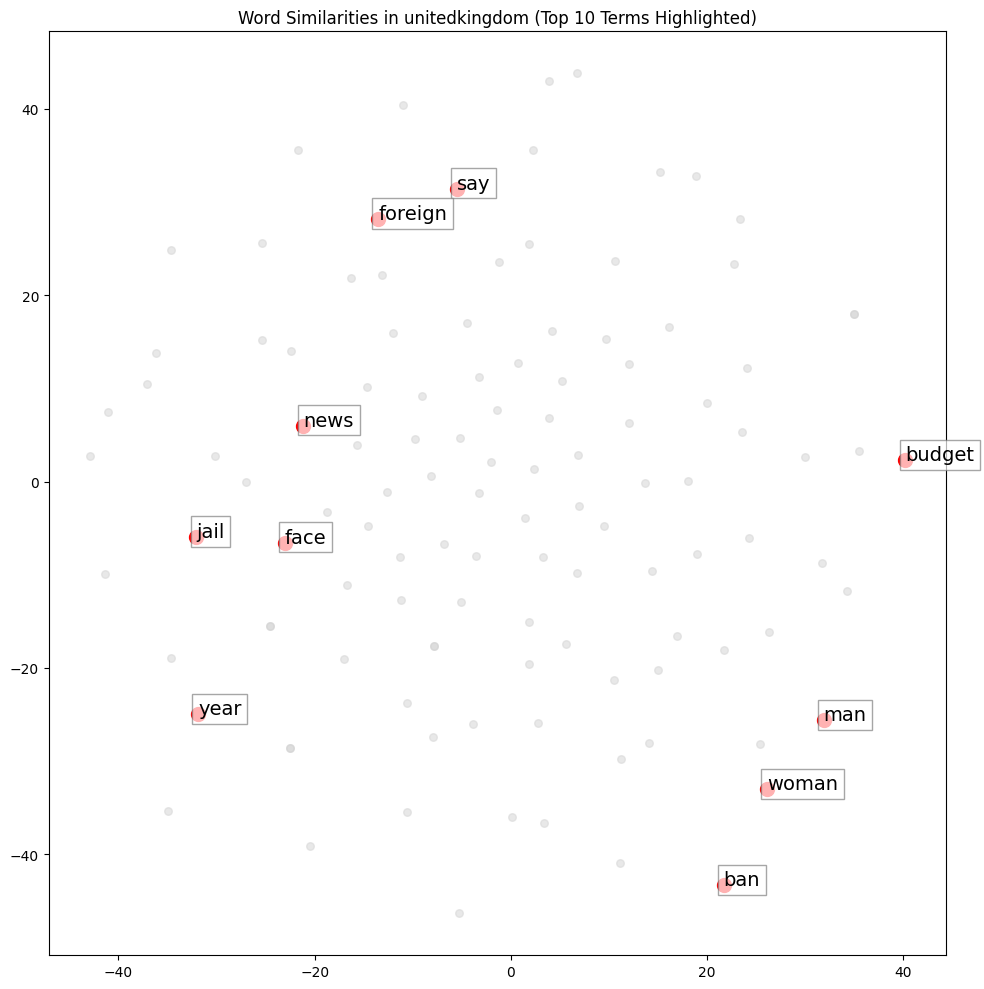

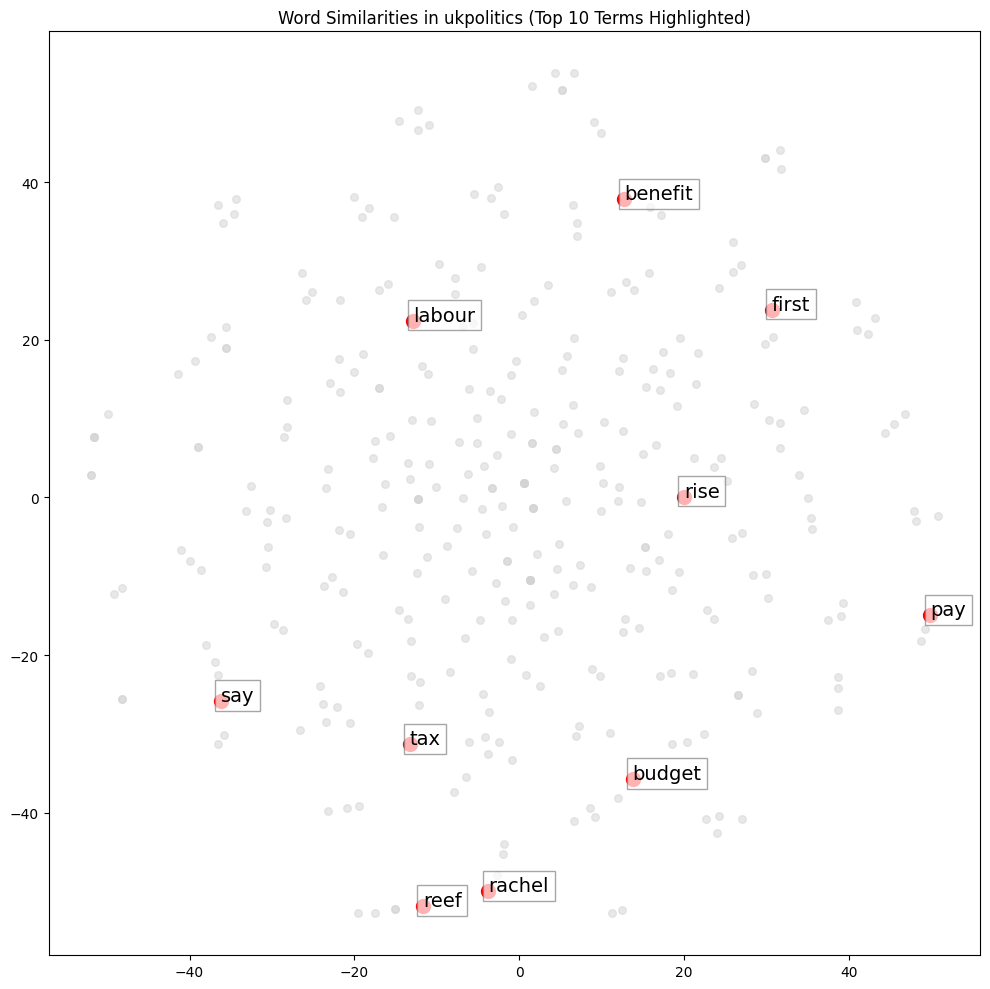

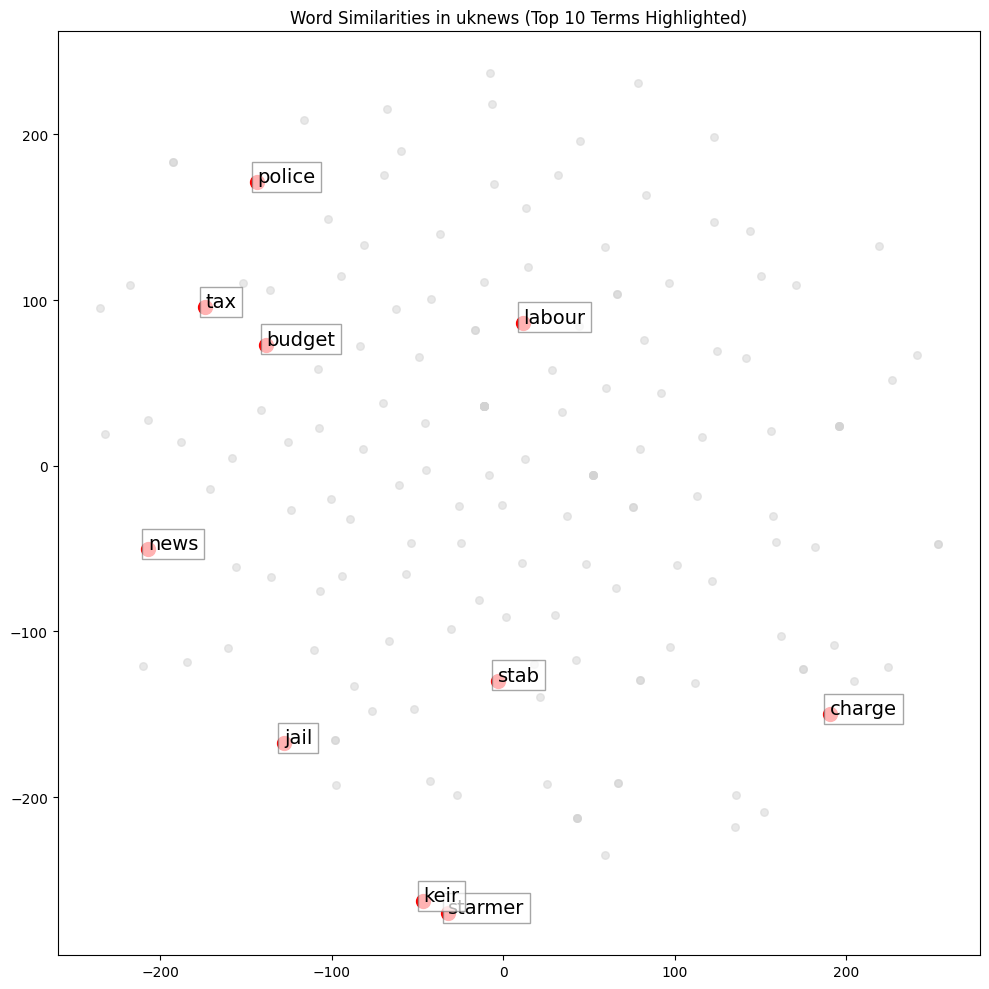

In [ ]:
from utils.analysis import plot_word_similarities_tsne

for sub in subs_of_interest:
    fig, ax = plot_word_similarities_tsne(results[sub]['tfidf_results']['tfidf_matrix'], 
                                     results[sub]['tfidf_results']['feature_names'],
                                     n_highlight=10, # Try changing this value
                                     title=sub)
    plt.show();

Now its your turn. Replace these subs with the ones of interest to you. Report the Jaccard, MDS, and t-SNE results for your subs. Toy around with the parameters as well as the size of your data set. 